In [67]:
import pandas as pd
total_dataset_clean = pd.read_stata("data_base_enrichie_totalement_clean.dta") 


On fait des stat desc avant de faire nos regressions. Normalité + correlation des variables


Statistiques croisées par territoire, sur nos variables dépendantes // checker hypothese de normalité

variable continue, on la transforme pour la regression. log transfo
log transfo permet d'avoir une var y quasi-normale. distrib normale aussi lorsqu'on croise avec le territoire.

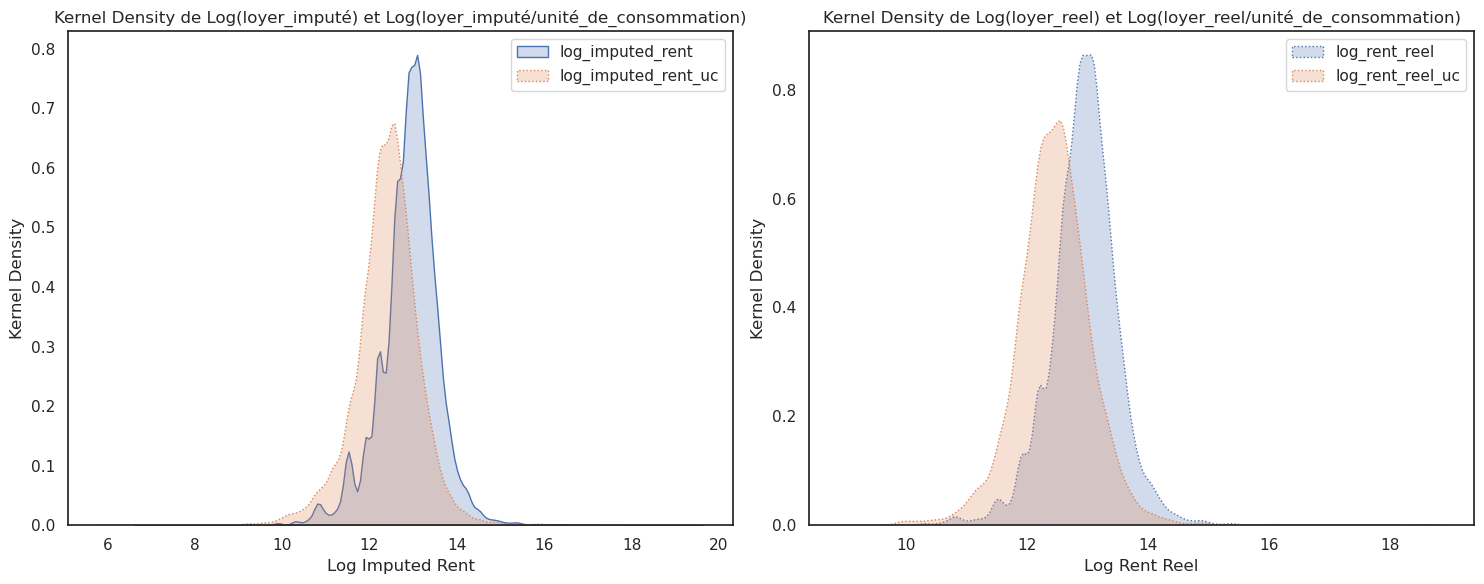

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

# configurer le graphique double
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

 # plot 1: 
# tracer la densité de log_imputed_rent
sns.kdeplot(total_dataset_clean['log_imputed_rent'], label='log_imputed_rent', fill=True, ax=axes[0])
# et de la densité de log_imputed_rent_uc
sns.kdeplot(total_dataset_clean['log_imputed_rent_uc'], label='log_imputed_rent_uc', fill=True, linestyle='dotted', ax=axes[0])
# définir les labels des axes et titre
plt.xlabel('Log Imputed Rent')
plt.ylabel('Kernel Density')
plt.title('Kernel Density de Log(loyer_imputé) et Log(loyer_imputé/unité_de_consommation)')

axes[0].set_xlabel('Log Imputed Rent')
axes[0].set_ylabel('Kernel Density')
axes[0].set_title('Kernel Density de Log(loyer_imputé) et Log(loyer_imputé/unité_de_consommation)')
axes[0].legend()

 # plot 2: 
# tracer la densité de log_rent_reel
sns.kdeplot(total_dataset_clean['log_rent_reel'], label='log_rent_reel', fill=True, linestyle='dotted', ax=axes[1])
# et de la densité de log_rent_reel_uc
sns.kdeplot(total_dataset_clean['log_rent_reel_uc'], label='log_rent_reel_uc', fill=True, linestyle='dotted', ax=axes[1])
# définir les labels des axes et titre
axes[1].set_xlabel('Log Rent Reel')
axes[1].set_ylabel('Kernel Density')
axes[1].set_title('Kernel Density de Log(loyer_reel) et Log(loyer_reel/unité_de_consommation)')
axes[1].legend()

plt.tight_layout() # ajuster la mise en page

plt.show() # afficher les graphiques


Statistiques croisées par territoire, sur nos variables de contrôles // checker randomisation

Pour celles de Utilrank, voir dans 4_outputs

age suit une distribution uniforme. les vars educ et marital_status: pour chaque territoire, on a une distribution similaire - evidemment les hauteurs des histogrammes sont differentes selon les territoires, car y a des categories de territoires plus populees que d'autres dans la base // pour l'age, chaque territoire est balancé entre male et femme (a part territoire 10, mais c'est ok c'est un territoire plus petit en terme d'echantillon + rural)

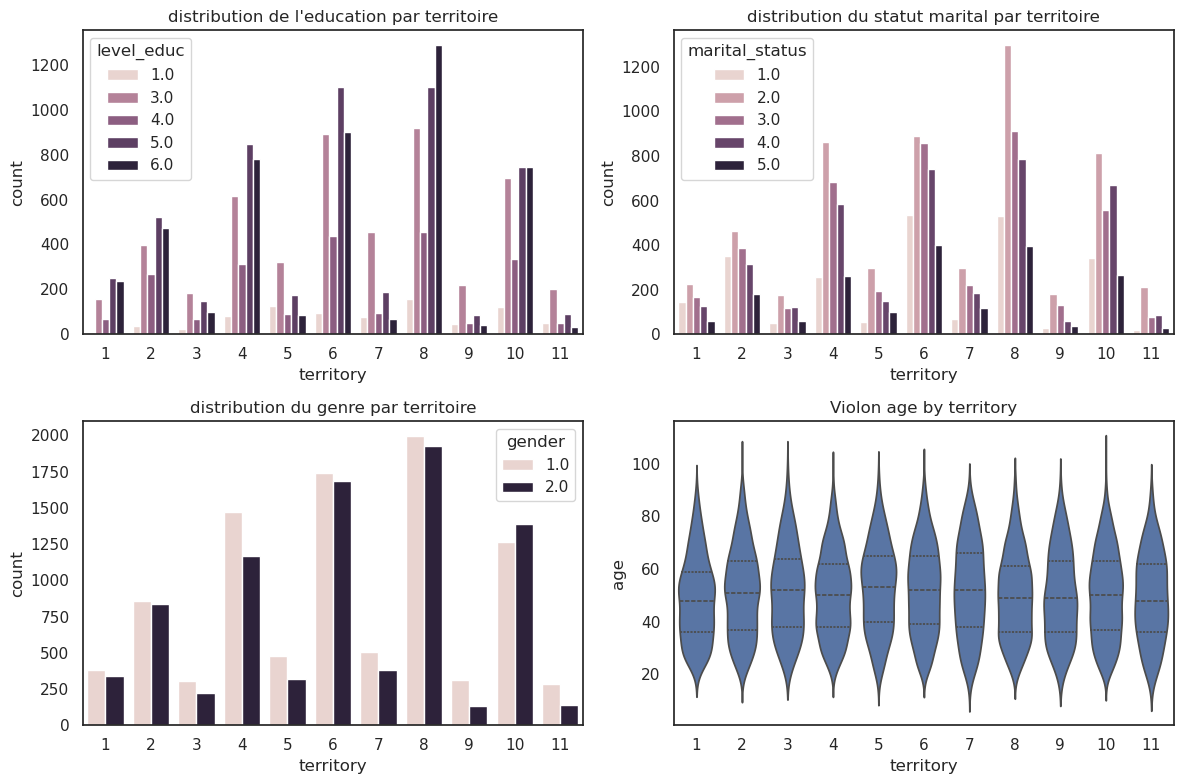

In [69]:
### Quelques stat desc

import seaborn as sns
import matplotlib.pyplot as plt

# pavage
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# graphique 1 : distribution de l'éducation par territoire
sns.countplot(x='territory', hue='level_educ', data=total_dataset_clean, ax=axes[0, 0])
axes[0, 0].set_title('distribution de l\'education par territoire')

# graphique 2 : distribution du statut marital par territoire
sns.countplot(x='territory', hue='marital_status', data=total_dataset_clean, ax=axes[0, 1])
axes[0, 1].set_title('distribution du statut marital par territoire')

# graphique 3 : distribution du genre par territoire
sns.countplot(x='territory', hue='gender', data=total_dataset_clean, ax=axes[1, 0])
axes[1, 0].set_title('distribution du genre par territoire')

# graphique 4 : distribution de l'âge par territoire
#sns.histplot(x='age', hue='territory', data=total_dataset_clean, kde=False, ax=axes[1, 1])
#axes[1, 1].set_title('distribution de l\'age par territoire')

sns.violinplot(x='territory', y='age', data=total_dataset_clean, inner="quartile", ax=axes[1, 1])
axes[1, 1].set_xlabel('territory')
axes[1, 1].set_ylabel('age')
axes[1, 1].set_title('Violon age by territory')
    # loi uniforme sur l'age, ok 

# ajuster la mise en page
plt.tight_layout()

# afficher les graphiques
plt.show()

Choix des variables pertinentes : tables de correlations

permet de voir quelles variables seront les plus pertinentes pour l'etude. surtout discuté dans 4_lasso_further_reg concernant la selection des variables. 

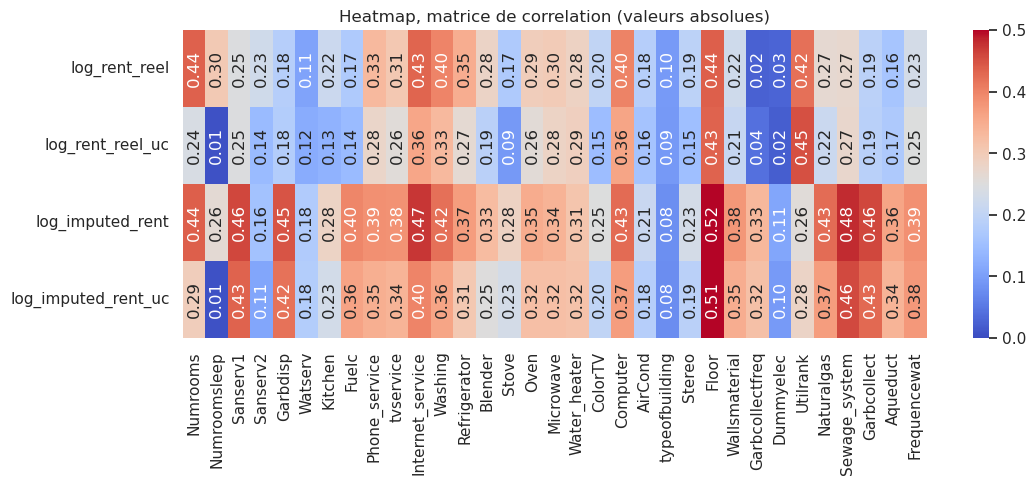

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your data is in a DataFrame called 'total_dataset_clean'
variables = ['Numrooms', 'Numroomsleep', 'Sanserv1', 'Sanserv2', 'Garbdisp', 'Watserv', 'Kitchen', 'Fuelc',
             'Phone_service', 'tvservice', 'Internet_service', 'Washing', 'Refrigerator', 'Blender', 'Stove',
             'Oven', 'Microwave', 'Water_heater', 'ColorTV', 'Computer', 'AirCond', 'typeofbuilding', 'Stereo',
             'Floor', 'Wallsmaterial','Garbcollectfreq','Dummyelec',
             'Utilrank', 'Naturalgas', 'Sewage_system', 'Garbcollect', 'Aqueduct', 'Frequencewat']

target_variables = ['log_rent_reel', 'log_rent_reel_uc', 'log_imputed_rent', 'log_imputed_rent_uc']

correlation_matrix = total_dataset_clean[variables + target_variables].corr().loc[target_variables, variables]

# Convert the correlation_matrix to a NumPy array and take the absolute values
correlation_matrix_abs = correlation_matrix.abs().to_numpy()

# Create a heatmap for the absolute values of the correlation matrix
plt.figure(figsize=(12, 4))
sns.heatmap(correlation_matrix_abs, annot=True, cmap="coolwarm", vmin=0, vmax=0.5, cbar=True, fmt='.2f', annot_kws={'rotation': 90},xticklabels=variables, yticklabels=target_variables)
plt.title('Heatmap, matrice de correlation (valeurs absolues)')
plt.show()

et on garde celles qui ont une correlation elevee par rapport a log_imputed_rent (>=0.29)

Finalement juste Numrooms, Floor, Sanserv1 : elles semblent aussi tres correlees avec certaines autres variables, donc elles sont pertinentes sur plusieurs dimensions

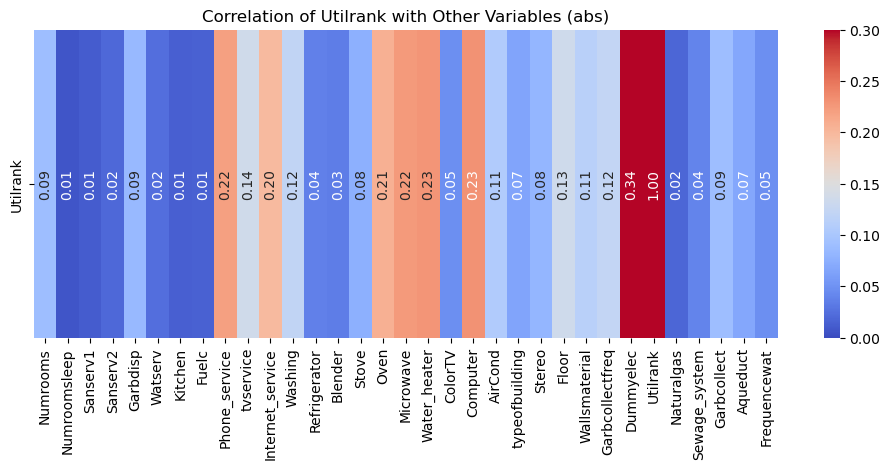

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your data is in a DataFrame called 'data'
variables = ['Numrooms', 'Numroomsleep', 'Sanserv1', 'Sanserv2', 'Garbdisp', 'Watserv', 'Kitchen', 'Fuelc',
             'Phone_service', 'tvservice', 'Internet_service', 'Washing', 'Refrigerator', 'Blender', 'Stove',
             'Oven', 'Microwave', 'Water_heater', 'ColorTV', 'Computer', 'AirCond', 'typeofbuilding', 'Stereo',
             'Floor', 'Wallsmaterial','Garbcollectfreq','Dummyelec',
             'Utilrank', 'Naturalgas', 'Sewage_system', 'Garbcollect', 'Aqueduct', 'Frequencewat']

# Select the relevant columns from the DataFrame
selected_data = total_dataset_clean[variables]

# Calculate the correlation matrix
correlation_matrix = selected_data.corr()

correlation_matrix = correlation_matrix.loc['Utilrank', :].abs()

plt.figure(figsize=(12, 4))
sns.heatmap(correlation_matrix.to_frame().T, annot=True, cmap="coolwarm", vmin=0, vmax=0.3, cbar=True, fmt='.2f', annot_kws={'rotation': 90})
plt.title('Correlation of Utilrank with Other Variables (abs)')
plt.show()


cerner deja les variables qui sont collineaires a utilrank, comme dummyelec.(vu que Utilrank prend deja en compte partiellement les amenites. voir le papier (Medina)[https://www.jstor.org/stable/20060492]  on ne garde que celles en bleues finalement dans la heatmap) 
on en rediscute dans 4_reg_intra_territoriale 

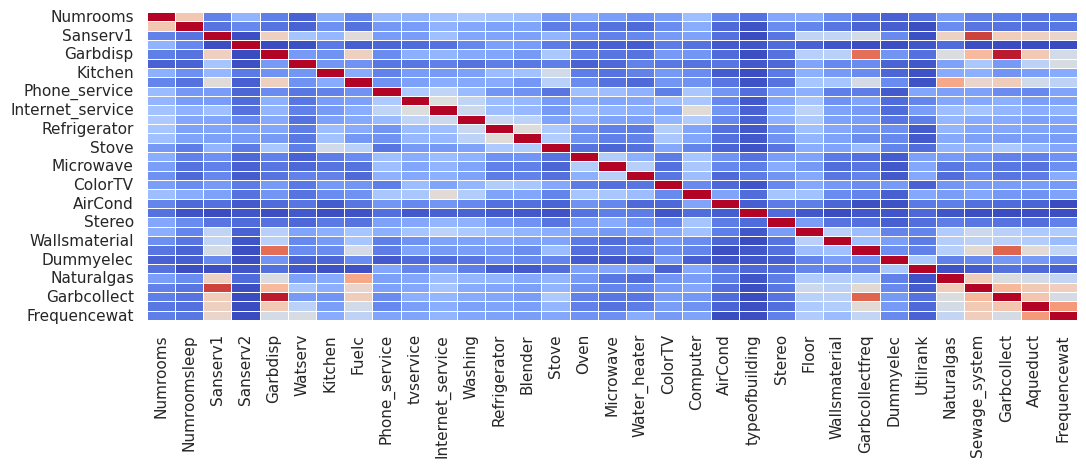

In [22]:



# Calculate the correlation matrix
correlation_matrix = selected_data.corr().abs()

plt.figure(figsize=(12, 4))
sns.set(style="white")
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", vmin=0, vmax=1, cbar=False, fmt='.2f', linewidths=.5,annot_kws={'rotation': 90})
plt.show()

In [35]:
from IPython.display import display, Markdown

markdown = """
Variable Utilrank : 

La théorie de la consommation en microéconomie nous conduit à examiner l'effet de revenu sur les dépenses en logement, et plus spécifiquement la variable Utilrank. La variable Utilrank capture des caractéristiques personnelles liées à la richesse d'un ménage et de sa géolocalisation, ce qui permet d'étudier l'interaction entre richesse et location.

En Colombie, la taxe sur les utilités (électricité) dépend du lieu où l'on vit au sein d'un territoire donné, niveau de taxe qui est capturé par la variable Utilrank. ce qui peut nous permettre d'observer les fortes inégalités intra-territoriales. En effet, la variable Utilrank correspond au niveau d'utilités accessible à l'individu (voir le descriptif de la variable 'P4030S1A1 Estrato para tarifa' (rang tarifaire pour l'electricité) dans [le dictionnaire de variables](https://microdatos.dane.gov.co/index.php/catalog/701/data-dictionary/F27?file_name=Cabecera%20-%20Vivienda%20y%20Hogares)), ce qui est particulièrement intéressant dans l'étude d'une structure monocentrique. Elle tient compte de l'interaction entre l'espace (où les gens vivent dans une couche urbaine donnée, que ce soit dans le centre, en périphérie ou dans des zones rurales) et leur statut socio-économique (le choix de l'endroit où ils vivent est conditionné par leur richesse individuelle) d'un individu donné, ce qui permet de tenir compte de la mixité sociale pour une couche urbaine donnée

Cette forte mixité sociale intra-territoiriale remet en question l'idée que la Colombie adopte une structure urbaine monocentrique : l'hypothèse selon laquelle l'activité économique est concentrée dans des zones denses, créant une demande accrue pour des commodités telles que le logement. Cette demande plus forte constitue un trade-off entre la disutilité de vivre en périphérie ou de payer davantage. Cet arbitrage pousse les gens hors du centre-ville. Comme mentionné précédemment, l'effet de mixité sociale découlant de la structure d'inégalité en Colombie va à l'encontre des effets d'agglomération des couches urbaines denses, ce qui nous amène à nous interroger sur la structure urbaine de la Colombie, qui pourrait être polycentrique ou monocentrique.

Donc dans la mesure où Utilrank capture le statut social d'une personne, il n'est pas nécessaire de contrôler par la richesse individuelle (salaire, dotations, indemnités, etc.).
"""
display(Markdown(markdown))



Variable Utilrank : 

La théorie de la consommation en microéconomie nous conduit à examiner l'effet de revenu sur les dépenses en logement, et plus spécifiquement la variable Utilrank. La variable Utilrank capture des caractéristiques personnelles liées à la richesse d'un ménage et de sa géolocalisation, ce qui permet d'étudier l'interaction entre richesse et location.

En Colombie, la taxe sur les utilités (électricité) dépend du lieu où l'on vit au sein d'un territoire donné, niveau de taxe qui est capturé par la variable Utilrank. ce qui peut nous permettre d'observer les fortes inégalités intra-territoriales. En effet, la variable Utilrank correspond au niveau d'utilités accessible à l'individu (voir le descriptif de la variable 'P4030S1A1 Estrato para tarifa' (rang tarifaire pour l'electricité) dans [le dictionnaire de variables](https://microdatos.dane.gov.co/index.php/catalog/701/data-dictionary/F27?file_name=Cabecera%20-%20Vivienda%20y%20Hogares)), ce qui est particulièrement intéressant dans l'étude d'une structure monocentrique. Elle tient compte de l'interaction entre l'espace (où les gens vivent dans une couche urbaine donnée, que ce soit dans le centre, en périphérie ou dans des zones rurales) et leur statut socio-économique (le choix de l'endroit où ils vivent est conditionné par leur richesse individuelle) d'un individu donné, ce qui permet de tenir compte de la mixité sociale pour une couche urbaine donnée

Cette forte mixité sociale intra-territoiriale remet en question l'idée que la Colombie adopte une structure urbaine monocentrique : l'hypothèse selon laquelle l'activité économique est concentrée dans des zones denses, créant une demande accrue pour des commodités telles que le logement. Cette demande plus forte constitue un trade-off entre la disutilité de vivre en périphérie ou de payer davantage. Cet arbitrage pousse les gens hors du centre-ville. Comme mentionné précédemment, l'effet de mixité sociale découlant de la structure d'inégalité en Colombie va à l'encontre des effets d'agglomération des couches urbaines denses, ce qui nous amène à nous interroger sur la structure urbaine de la Colombie, qui pourrait être polycentrique ou monocentrique.

Donc dans la mesure où Utilrank capture le statut social d'une personne, il n'est pas nécessaire de contrôler par la richesse individuelle (salaire, dotations, indemnités, etc.).


In [24]:
result = pd.crosstab(total_dataset_clean['territory'], total_dataset_clean['Utilrank'])
result

Utilrank,1.0,2.0,3.0,4.0,5.0,6.0,9.0
territory,,,,,,,
1,88,296,248,62,14,15,0
2,324,561,580,109,72,21,30
3,228,141,113,9,0,0,35
4,864,943,536,200,48,44,10
5,492,221,30,14,0,0,40
6,685,1326,1012,249,87,50,17
7,458,304,47,0,0,0,76
8,1262,1423,887,249,31,31,39
9,236,112,0,0,0,0,94


In [30]:
markdown = """
On peut deja voir une structure monocentrique : On voit que l'eloignement du centre vers la peripherie du centre urbain (prendre les territoires deux à deux, et comparer le territoire pair avec son prochain impair. Exemple : 2->3 // 4-5 ...etc.) diminue la proportion d'Utilrank élevés (on voit que la distribution se décale vers la gauche). 
Le niveau de richesse aggrege diminue à mesure que l'on s'eloigne du centre urbain.

Ne pas interpreter Utilrank ==9 (C'est une categorie non classée)
"""
display(Markdown(markdown))


On peut deja voir une structure monocentrique : On voit que l'eloignement du centre vers la peripherie du centre urbain (prendre les territoires deux à deux, et comparer le territoire pair avec son prochain impair. Exemple : 2->3 // 4-5 ...etc.) diminue la proportion d'Utilrank élevés (on voit que la distribution se décale vers la gauche). 
Le niveau de richesse aggrege diminue à mesure que l'on s'eloigne du centre urbain.

Ne pas interpreter Utilrank ==9 (C'est une categorie non classée)


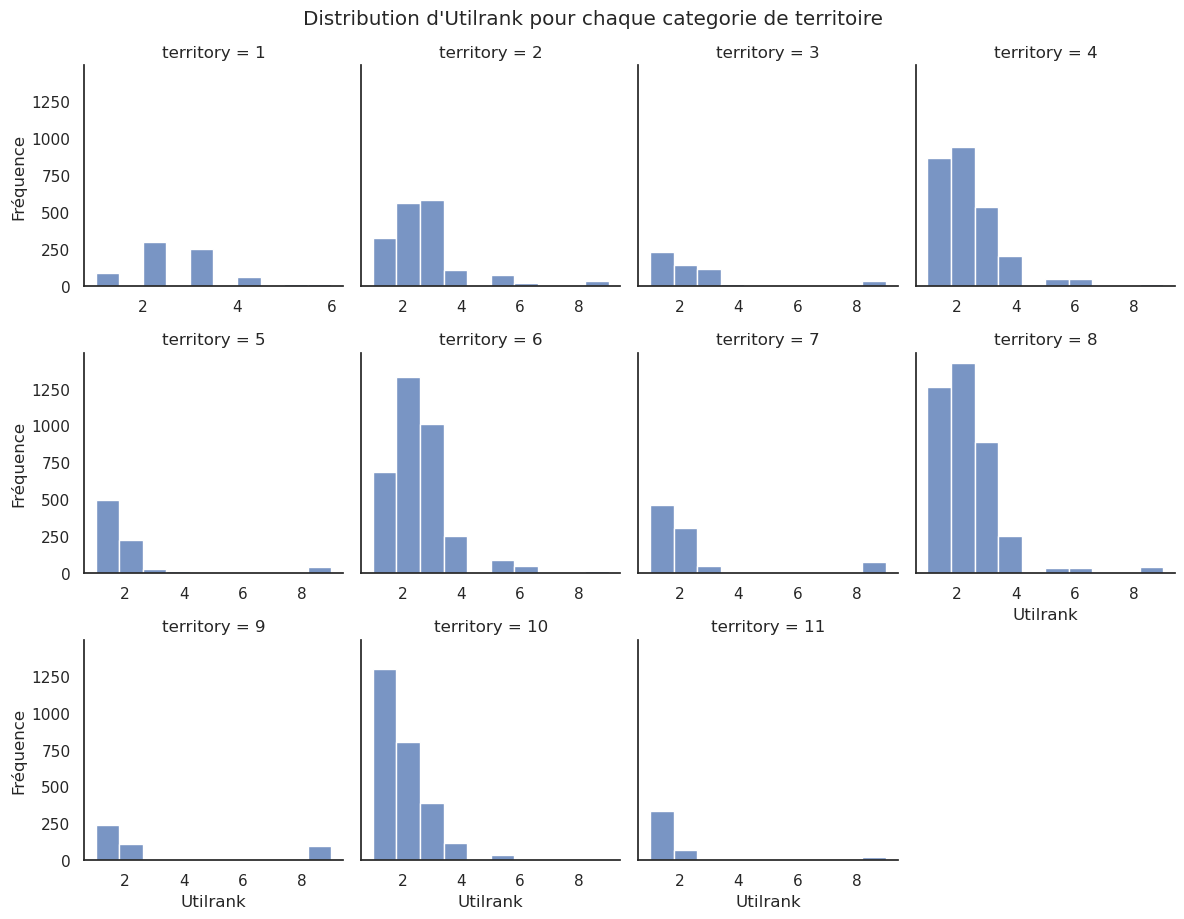

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# avec seaborn, on fait un pavage pour grapher dedans
g = sns.FacetGrid(total_dataset_clean, col="territory", col_wrap=4, height=3, sharex=False)

# distribution d'Utilrank pour chaque categorie de territoire
g.map(sns.histplot, "Utilrank", bins=10, kde=False)

# axes, labels, titres
g.set_axis_labels("Utilrank", "Fréquence")
g.fig.suptitle("Distribution d'Utilrank pour chaque categorie de territoire", y=1.02)

plt.show() #notre plot

<Axes: xlabel='territory', ylabel='Utilrank'>

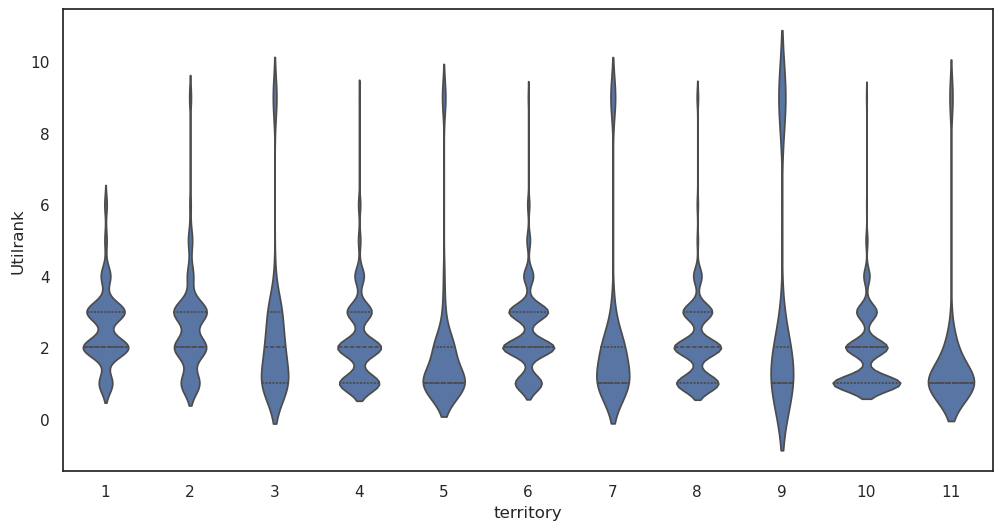

In [31]:
#mieux voir les distributions skewed

import seaborn as sns
import matplotlib.pyplot as plt

# on fait un violin plot avec seaborn
plt.figure(figsize=(12, 6))
sns.violinplot(x="territory", y="Utilrank", data=total_dataset_clean, inner="quartile")


Sources de ce Notebook : 

[World Bank (2023)](https://data.worldbank.org/indicator/SL.TLF.TOTL.IN?locations=CO)